In [88]:
import sys
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
import torch
from torch.utils import model_zoo
from collections import OrderedDict

sys.path.append('../src')
sys.path.append('../src')
from utils import DataHandler
import factory

In [2]:
dh = DataHandler()

In [58]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img)
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


def concat_tiles(image_list):
    image = []
    row_num = int(np.sqrt(len(image_list)))

    for i in range(row_num):
        v = [image_list[(row_num * i) + j] for j in range(row_num)]
        image.append(cv2.hconcat(v))

    return cv2.vconcat(image)

    
def show_gradcam(model, imga_id,shuffle=False):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    tiles = []
    for i in range(36):
            tile = cv2.imread(f'../data/input/train_tile_256x36/{imga_id}_{i}.png')
            tiles.append(tile)
    if shuffle:
        random.shuffle(tiles)
    img = concat_tiles(tiles)
#     img = cv2.imread(f'../data/input/train_images/{img_id}.png')
    
    features_fn = nn.Sequential(*list(model.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
    
    input_data = torch.tensor(img.reshape(1, img.shape[2], img.shape[0], img.shape[1])).to(device).float()
#     pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), k=1)
    pp, cc = torch.topk(model(input_data), k=1)
    sal = GradCam(input_data.to(device), cc[0][0], features_fn, classifier_fn)
#     print(sal)
    img_sal = cv2.resize(sal, img.shape[0:2])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    ax1.imshow(img)

    ax2.imshow(img)
    ax2.imshow(np.array(img_sal), alpha=0.5, cmap='jet')

# Main

In [59]:
# log_dir = Path('../logs/clf_resnet18_20200703133354_0.827/')
# cfg = dh.load(log_dir / 'config.yml')
# oof = np.load(log_dir / 'oof.npy')

log_dir = Path('../logs/ordinal_reg_resnet34_20200712230026_0.776/')
cfg = dh.load(log_dir / 'config.yml')
oof = np.load(log_dir / 'oof_target_1.npy')

In [60]:
train_df = pd.read_csv('../data/input/train.csv')
drop_idx1 = np.load('../pickle/duplicate_img_idx.npy')
drop_idx2 = np.load('../pickle/noise_idx.npy')
drop_idx = np.unique(np.concatenate([drop_idx1, drop_idx2]))

train_df = train_df.drop(drop_idx, axis=0).reset_index(drop=True)

trn_x, val_x = train_test_split(train_df,
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=2020)
val_x['oof'] = 1 / (1 + np.exp(-1 * oof))

/home/naoki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg.model.multi_gpu = False

model = factory.get_model(cfg).to(device)
model.load_state_dict(torch.load(log_dir / 'weight_best_target_1.pt'))

<All keys matched successfully>

True Label:  0
OOF:  0.9999988179105517


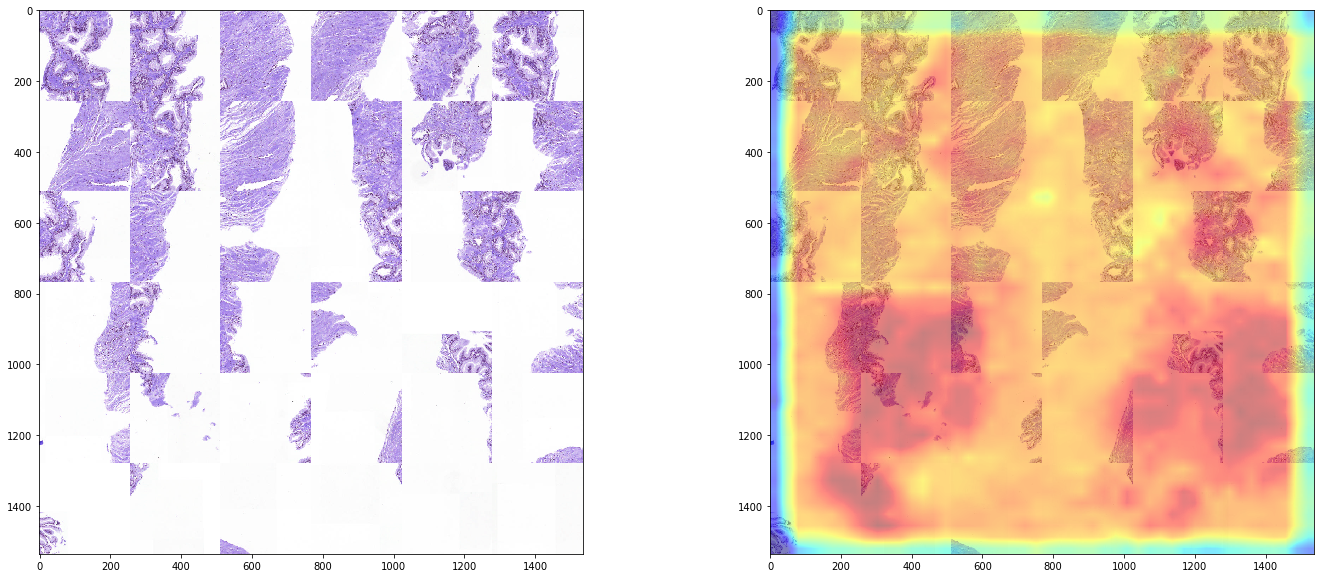

In [89]:
img_id = 'b801c926e3101268f1b816bd658bcc2f'

idx = val_x[val_x['image_id'] == img_id].index
print('True Label: ', val_x.loc[idx, 'isup_grade'].values[0])
print('OOF: ', val_x.loc[idx, 'oof'].values[0])

show_gradcam(model, img_id, shuffle=False)

In [87]:
val_x['diff'] = np.abs(val_x['isup_grade'] - val_x['oof'])
val_x.sort_values(by='oof')

/home/naoki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_id,data_provider,isup_grade,gleason_score,oof,diff
1637,2a1da196c725cd74cff0d64e7a006551,karolinska,0,0+0,0.000512,0.000512
2394,3d942bca61ac77578a03d8405dab4af4,karolinska,5,5+5,0.001468,4.998532
659,1115d114a4339de8dd9f36d6465c6d57,karolinska,4,4+4,0.001933,3.998067
9902,f6a5026c3875a441ac93945bd4ba9c18,radboud,2,3+4,0.002202,1.997798
6693,a7542dcc3123f9cce837cd93f13c0a27,karolinska,1,3+3,0.002585,0.997415
...,...,...,...,...,...,...
5844,934f3bcb20dfdd3e184f53df0383b9e0,radboud,4,3+5,0.999998,3.000002
7390,b801c926e3101268f1b816bd658bcc2f,radboud,0,negative,0.999999,0.999999
9549,ee969b43c03669148a16cd7246e3ddd0,karolinska,1,3+3,0.999999,0.000001
5056,80628cfdceb87d93ff1bc91e23fb5c92,radboud,4,4+4,0.999999,3.000001
